In [5]:
%run "01 - Data Processing.ipynb"  # Data Processing Library Import

In [6]:
import toml
from collections import defaultdict
config = toml.load('config.toml')
config = defaultdict(lambda : None, config)

# Boilerplate

In [30]:
def test_visualizations(y_score, y_pred, y_true):
    pass

def get_model_and_data():
    pass

class LightningWrapper(pl.LightningModule):
    """
    Wrapper module which encapsulates all boiler plate code for training neural network (training/validation/testing).
    """

    def __init__(self, hparams):
        super(LightningWrapper, self).__init__()
        self.hparams = hparams
        self.network, self.train_set, self.val_set = get_model_and_data()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # add empty channel dimension
        return self.network(x)

    def generate_embedding(self, x):
        x = x.unsqueeze(1)  # add empty channel dimension
        return self.network.generate_embedding(x)

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_out = self(x)

        y_score = F.softmax(y_out, dim=1)
        _, y_pred = torch.max(y_score, 1)

        return {'y_score': y_score, 'y_pred': y_pred, 'y_true': y_true}

    def validation_epoch_end(self, outputs):
        # Get y_score / y_pred
        y_score = torch.cat([x['y_score'] for x in outputs])
        y_pred = torch.cat([x['y_pred'] for x in outputs])
        y_true = torch.cat([x['y_true'] for x in outputs])

        # Metrics:
        log = {
            'val_accuracy': accuracy(y_pred, y_true),
            'val_f1': f1_score(y_pred, y_true),
            # 'Confusion Matrix': confusion_matrix(y_pred, y_true)
        }

        log['step'] = self.current_epoch
        log['log'] = copy.deepcopy(log)
        return log

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.hparams.batch_size, num_workers=4,
                          pin_memory=True)
    
    def test_dataloader(self):
        return self.val_dataloader()
    
    def test_step(self, batch, batch_idx):
        x, y_true = batch

        y_out = self(x)

        y_score = F.softmax(y_out, dim=1)
        _, y_pred = torch.max(y_score, 1)

        y_score = F.softmax(y_out, dim=1)
        _, y_pred = torch.max(y_score, 1)

        return {'y_score': y_score, 'y_pred': y_pred, 'y_true': y_true}

    def test_epoch_end(self, outputs):
        # Get y_score / y_pred
        y_score = torch.cat([x['y_score'] for x in outputs])
        y_pred = torch.cat([x['y_pred'] for x in outputs])
        y_true = torch.cat([x['y_true'] for x in outputs])
        
        test_visualizations(y_score, y_pred, y_true)

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_out = self(x)

        ret = {'loss': F.cross_entropy(y_out, y_true)}

        y_score = F.softmax(y_out, dim=1)
        _, y_pred = torch.max(y_score, 1)

        ret['y_score'] = y_score
        ret['y_pred'] = y_pred
        ret['y_true'] = y_true

        return ret

    def training_epoch_end(self, outputs):
        # Get y_score / y_pred
        y_score = torch.cat([x['y_score'] for x in outputs])
        y_pred = torch.cat([x['y_pred'] for x in outputs])
        y_true = torch.cat([x['y_true'] for x in outputs])

        # Metrics:
        log = {
            'train_accuracy': accuracy(y_pred, y_true),
            'train_f1': f1_score(y_pred, y_true),
            # 'Confusion Matrix': confusion_matrix(y_pred, y_true)
        }

        pass

        log['step'] = self.current_epoch
        log['log'] = copy.deepcopy(log)
        return log

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.hparams.batch_size, shuffle=True, num_workers=4,
                          pin_memory=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

# Network Architecture

In [9]:
class PhonoNet(nn.Module):
    def __init__(self, dropout=0.1):
        super(PhonoNet, self).__init__()

        self.encoder = nn.Sequential(OrderedDict([
            ('norm0', nn.BatchNorm2d(1)),
            ('conv1', nn.Conv2d(1, 64, 3, padding=1)),
            ('relu1', nn.LeakyReLU()),
            ('norm1', nn.BatchNorm2d(64)),
            ('pool1', nn.MaxPool2d([1, 2])),
            ('drop1', nn.Dropout(p=dropout)),

            ('conv2', nn.Conv2d(64, 128, 3, padding=1)),
            ('relu2', nn.LeakyReLU()),
            ('norm2', nn.BatchNorm2d(128)),
            ('pool2', nn.MaxPool2d([1, 3])),
            ('drop2', nn.Dropout(p=dropout)),

            ('conv3', nn.Conv2d(128, 150, 3, padding=1)),
            ('relu3', nn.LeakyReLU()),
            ('norm3', nn.BatchNorm2d(150)),
            ('pool3', nn.MaxPool2d([4, 2])),
            ('drop3', nn.Dropout(p=dropout)),

            ('conv4', nn.Conv2d(150, 200, 3, padding=1)),
            ('relu4', nn.LeakyReLU()),
            ('norm4', nn.BatchNorm2d(200)),
            ('gba', nn.AdaptiveAvgPool2d([1, 1])),
            ('drop4', nn.Dropout(p=dropout))
        ]))

        self.fc1 = nn.Linear(200, 40)

    def forward(self, x):
        """
        :param x: tensor of shape (-1, 1, 12, 5000)
        :return: resultant tensor after operations
        """
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.fc1(x)
        return x

    def generate_embedding(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)  # Flatten
        return x

# Experiments

In [31]:
args = AttributeDict({'learning_rate' : 0.01, 'batch_size' : config['training']['batch_size'], 'chunk_size' : config['data']['chunk_size']})

fcd = FullChromaDataset(json_path=config['data']['metadata'],
                        data_folder=config['data']['chroma_folder'],
                        include_mbids=json.load(open(config['data']['limit_songs'])))

fcd_train, fcd_val = fcd.greedy_split(train_size=0.75)
train = ChromaChunkDataset(fcd_train, chunk_size=args.chunk_size, augmentation=transpose_chromagram)
val = ChromaChunkDataset(fcd_val, chunk_size=args.chunk_size)

network = PhonoNet()

def get_model_and_data():
    return network, train, val

model = LightningWrapper(args)

trainer = Trainer(gpus=1, logger=TensorBoardLogger('tb_logs'), max_epochs=2,
                  checkpoint_callback=ModelCheckpoint(monitor='val_accuracy', mode='max'),
                  progress_bar_refresh_rate=20)

# Find learning rate
lr_finder = trainer.lr_find(model)
new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr
print(f"Optimal Learning Rate: {new_lr}")

trainer.fit(model)




Loading Chromagram Files:   0%|          | 0/300 [00:00<?, ?it/s]


Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 2160.59it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | network | PhonoNet | 526 K 


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

LR finder stopped early due to diverging loss.

  | Name    | Type     | Params
-------------------------------------
0 | network | PhonoNet | 526 K 


Optimal Learning Rate: 7.585775750291837e-08


1

Hi Friends!



# Evaluate Model

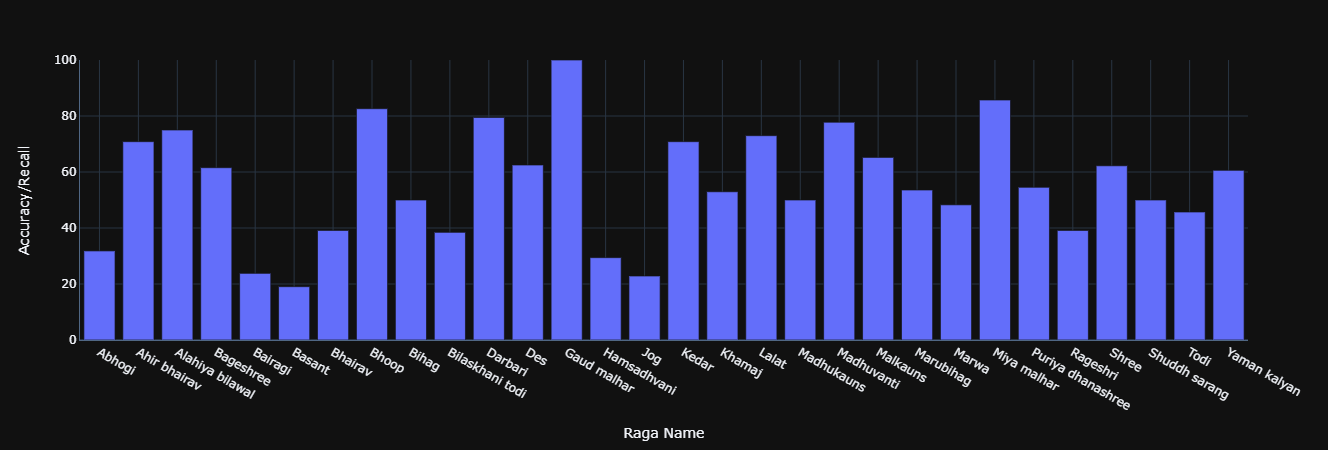

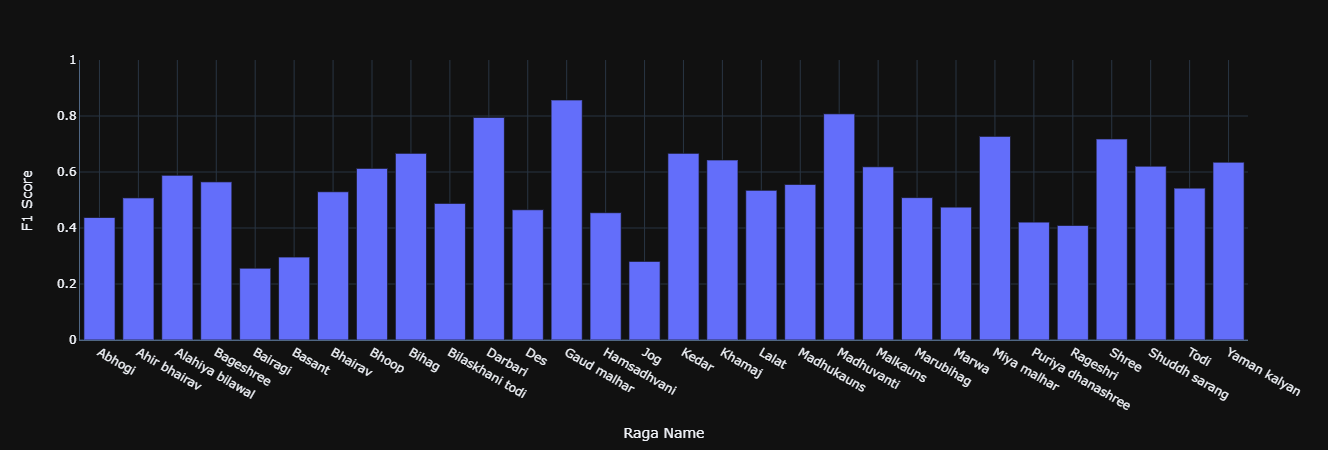

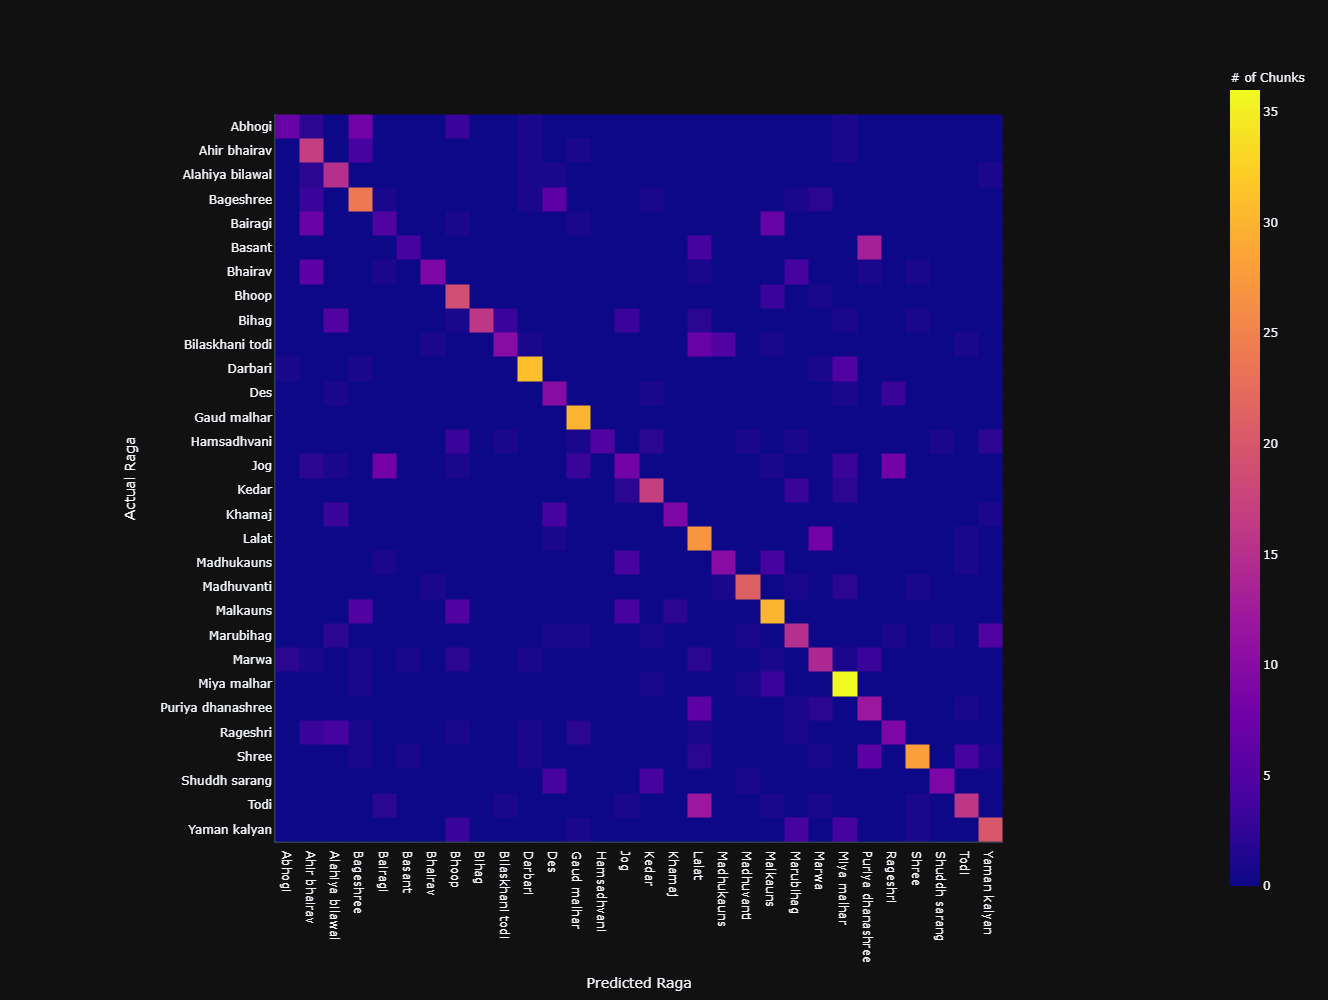

In [40]:
model = LightningWrapper.load_from_checkpoint('/home/jupyter/default/version_0/checkpoints/epoch=55.ckpt')

def test_visualizations(y_score, y_pred, y_true):
    # Plot Accuracy vs. Class
    cm = confusion_matrix(y_pred, y_true).cpu().numpy()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = px.bar(x=get_raga_list(fcd), y=100 * cm.diagonal(), labels={'x': 'Raga Name', 'y':'Accuracy/Recall'})
    fig.update_layout(yaxis=dict(range=[0, 100]))
    fig.show()
    
    # Plot F1 vs. Class
    f1 = pl.metrics.sklearns.F1(average=None)
    fig = px.bar(x=get_raga_list(fcd), y=f1(y_true.cpu(), y_pred.cpu()).numpy(), labels={'x': 'Raga Name', 'y':'F1 Score'})
    fig.update_layout(yaxis=dict(range=[0, 1]))
    fig.show()
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_pred, y_true).cpu().numpy()
    fig = px.imshow(cm, x=get_raga_list(fcd), y=get_raga_list(fcd), labels=dict(x="Predicted Raga", y="Actual Raga", color="# of Chunks"),)
    fig.update_layout(
    autosize=False, width=1000, height=1000)
    fig.show()
    

trainer.test(model)